## Diffusion Limited Aggregation

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

### SOR solver

In [120]:
def SOR_solver(i, j, n_i, c_k, c_k_1, w=1.8):

    # boundary conditions
    if i == 0:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
    elif i == n_i-1:
        c_new = w/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
        
    else:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]

    return c_new

In [121]:
def growth_candi_generator(obj_old):
    # create a blank growth candidate set
    candidates = set()

    obj_inter = obj_old.copy()

    # generate the growth candidates
    for (i, j)  in obj_old:

        if i == 0:
            g_i1, g_j1, g_j0 = (i+1, j), (i, j+1), (i, j-1)
            obj_inter.update([g_i1, g_j1, g_j0])
        elif j == 0:
            g_i1, g_i0, g_j1 = (i+1, j), (i-1, j), (i, j+1)
            obj_inter.update([g_i1, g_i0, g_j1])
        else:
            g_i1, g_i0, g_j1, g_j0 = (i+1, j), (i-1, j), (i, j+1), (i, j-1)

            # update the neighbouring growth candidate
            obj_inter.update([g_i1, g_i0, g_j1, g_j0])

        # check if the growth candidates are in the cluster, 
        # and pick the ones that are not in the old object
        growth_candi = obj_inter - obj_old

        # Add the growth candidate to the memory
        candidates.update(growth_candi)
    
    # return all the growth candidates
    return candidates

In [133]:
def growth_candi_selector(c_s, candi_all, n=1):
    
    # calculate the sum of c_candidate
    c_all = 0
    c_store = []

    candi_all = list(candi_all)

    for (i, j) in candi_all:
        c_candi = np.around(c_s[i, j], decimals=4)
        # print(c_candi, end=',')

        # calculate the sum of c_candidate
        c_all += c_candi

        # Store the current c_candidate value
        c_store.append(c_candi)
    
    # print('\n')

    # calculate tbe probablity of each growth candidate
    p_c = np.array(c_store) ** n / c_all ** n

    # select the real growth candidate
    c_add = np.random.choice(c_store, size=1, p=p_c)
    candidate = candi_all[c_store.index(c_add)]

    return {candidate}

In [123]:
def object_detector(i, j, obj):

    passcheck = 0

    # check if the current lattice point is inside the dla object
    if (i, j) in obj:
        passcheck = 1

    return passcheck

In [124]:
def DLA_sor(c_sol, obj, max_ite=5000, w=1.8, e=1e-5, N=50):
    ##########################################################
    # Initialize valuse
    max_ite = max_ite
    e = e
    ###########################################################
    # Create tracker matrix
    # c_store_s = np.zeros((max_ite+1, N, N))
    # c_store_s[:, :, -1].fill(1)

    # Store the convergence measure delta
    # delta_s = np.zeros(max_ite+1)

    # set the object calue to 0
    for (i, j) in obj:
        c_sol[i, j] = 0

    # create matrix to store function value at the last step
    c_keep_s = np.copy(c_sol)

    # Create matrix to store function value at the current step
    c_s = c_sol
    ##################################################################################
    # apply the sor method (pity that I don't know how to enable parellel computing :( )
    for _ in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                ####################################################################          
                # Check if the point (i,j) lies within the sink!
                passcheck = object_detector(i=i, j=j, obj=obj)
                if passcheck == 0:
                    c_s[i, j] = SOR_solver(i, j, n_i=N, c_k=c_keep_s, c_k_1=c_s, w=w)
                else:
                    c_s[i, j] = 0
                ####################################################################
        
        # Update the tracker
        # c_store_s[k+1, :, :] = c_s
        
        # apply the threshold
        diff_s = c_s - c_keep_s
        # delta_s[k] = abs(max(diff_s.max(), diff_s.min(), key=abs))
        delta_s = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s < e:
            break

        # update the store matrix
        c_keep_s = np.copy(c_s)
    #####################################################################################

    return c_s


In [131]:
def implement_dla(c_sol, obj_0, N, max_iteration=100):
    obj = obj_0

    # simulate the DLA
    for i in range(max_iteration):
        # compute the PDE solution with dla object 
        c_sol = DLA_sor(c_sol=c_sol, obj=obj, N=N)

        # update the dla object
        growth_candis = growth_candi_generator(obj_old=obj)
        candidate = growth_candi_selector(c_s=c_sol, candi_all=growth_candis, n=1)
        obj.update(candidate)

        print(i, end=',')

    return c_sol, obj

In [134]:
if __name__ == '__main__':
    # define the interval size we need
    N = 100

    # Start the simulation with the analytical solution
    c_0 = np.linspace(0, 1, N)
    c_analytic = np.tile(c_0, (N, 1))
    ite = 500

    # create the original dla object, it is a set!
    obj_origin = {(50, 0)}

    c_dla, obj_final = implement_dla(c_sol=c_analytic, obj_0=obj_origin, N=N, max_iteration=ite)


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

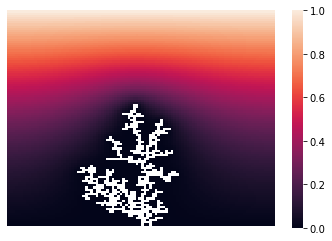

In [152]:
sns.heatmap(np.flipud(c_dla.T), cbar=True, xticklabels=False, yticklabels=False, mask=np.flipud(c_dla.T)==0)
plt.show()

Question: Maybe we can use the property of $\textbf{set}$ to reduce the time required to solve the diffusion equation?